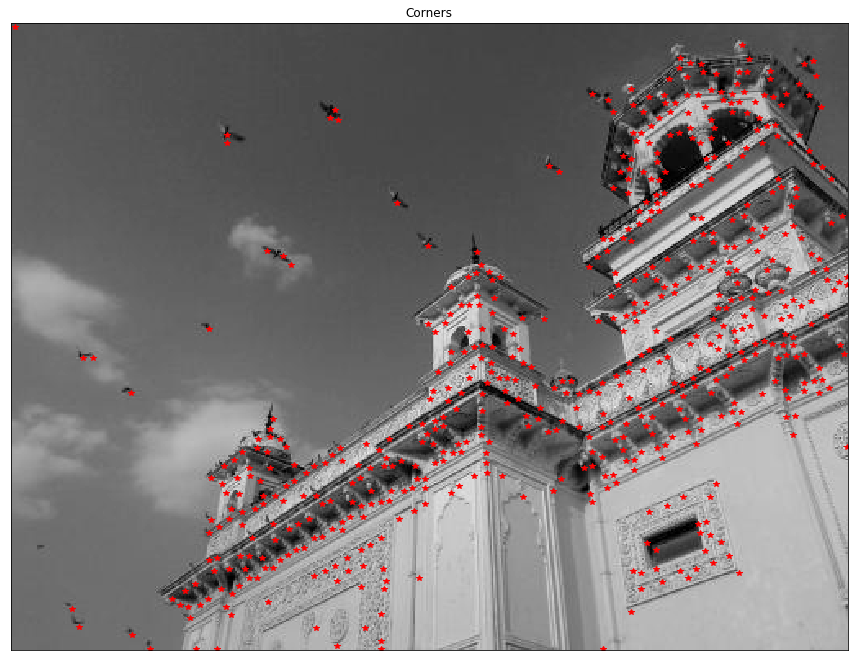

Finished.


In [27]:
"""
Harris Corner Detection
ECSE415 Fall 2017, Assignment #2, Problem 1

Author: Gary Corcoran

Date: Oct. 20th, 2017

"""
import cv2
import numpy as np
import matplotlib.pyplot as plt

""" Filter Image """
def filter(img, kernel):
    """
    Filter image with kernel.
    
    @param img: image to apply filter on
    @param kernel: kernel to convolve with image
    
    @return img_filtered: resultant filtered image
    """
    height, width = img.shape[0:2]
    offset = kernel.shape[0]//2
    # pad image
    img_pad = np.zeros((height+(2*offset), width+(2*offset)))
    img_pad[offset:height+offset, offset:width+offset] = img
    # filtered image
    img_filtered = np.zeros((height, width))
    for x in range(offset, height+offset):
        for y in range(offset, width+offset):
            # convolve
            total = sum(sum(img_pad[x-offset:x+offset+1, y-offset:y+offset+1] * kernel))
            img_filtered[x-offset, y-offset] = total
    return img_filtered

""" Apply Non Max"""
def apply_non_max(H, k_size):
    """
    Apply Non-Maximum Suppression.
    
    @param H: input cornerness image
    @param k_size: window size of non-max suppression
    
    @return H_pad: non-maximum suppressed image
    """
    height, width = H.shape[0:2]
    offset = k_size//2
    # pad image
    H_pad = np.zeros((height+k_size-1, width+k_size-1))
    H_pad[offset:-offset, offset:-offset] = H
    for row in range(height):
        for col in range(width):
            # window region
            window = H_pad[row:row+k_size, col:col+k_size]
            # suppress non-max
            window[window != window.max()] = 0
    return H_pad
    
# read image
img = cv2.imread('/home/gary/opencv/samples/data/home.jpg', 0)
height, width = img.shape[0:2]

# between 0.04 - 0.15
alpha = 0.04

# Sobel derivatives
sobelx = np.array((
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
))
sobely = np.array((
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
))
# apply Sobel filters
Ix = filter(img, sobelx)
Iy = filter(img, sobely)

# compute squared terms (element-wise)
Ixx = Ix * Ix
Iyy = Iy * Iy
Ixy = Ix * Iy

# Gaussian kernel
gauss_kernel = np.array((
    [1, 4, 7, 4, 1],
    [4, 16, 26, 16, 4],
    [7, 26, 41, 26, 7],
    [4, 16, 26, 16, 4],
    [1, 4, 7, 4, 1]
))
# apply Gaussian smoothing
Gxx = cv2.GaussianBlur(Ixx, (5, 5), 0)
Gyy = cv2.GaussianBlur(Iyy, (5, 5), 0)
Gxy = cv2.GaussianBlur(Ixy, (5, 5), 0)

# computer cornerness function
H = Gxx * Gyy - (Gxy**2) - alpha * (Gxx + Gyy)**2
# normalize the Harris cornermap between 0 and 1
H_min = H - H.min()
H_norm = H_min / (H_min.max())

# apply non-maximum suppression
H_supp = apply_non_max(H_norm, 5)

# threshold corners
thres = 0.13
H_supp[H_supp <= thres] = 0
H_supp[H_supp > thres] = 1

# find indices
idx, idy = np.where(H_supp == 1)
in_idx = []
in_idy = []
# make sure indices are inside original image
for pair in zip(idx, idy):
    if pair[0] < height and pair[1] < width:
        in_idx.append(pair[0])
        in_idy.append(pair[1])

# plot using matplotlib
plt.figure(figsize=(15,15))
plt.imshow(img, cmap='gray'), plt.title('Corners')
plt.xticks([]), plt.yticks([])
plt.plot(in_idy, in_idx, 'r*')
plt.show()
print("Finished.")


/home/gary/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in true_divide
/home/gary/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide


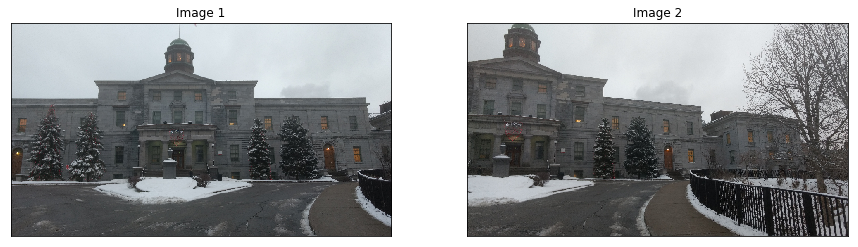

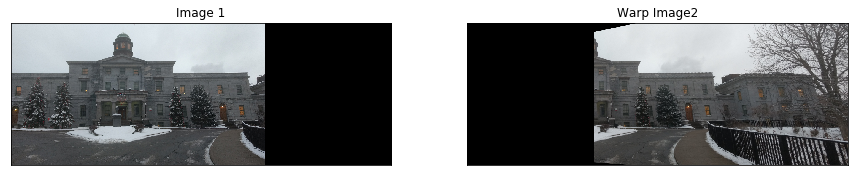

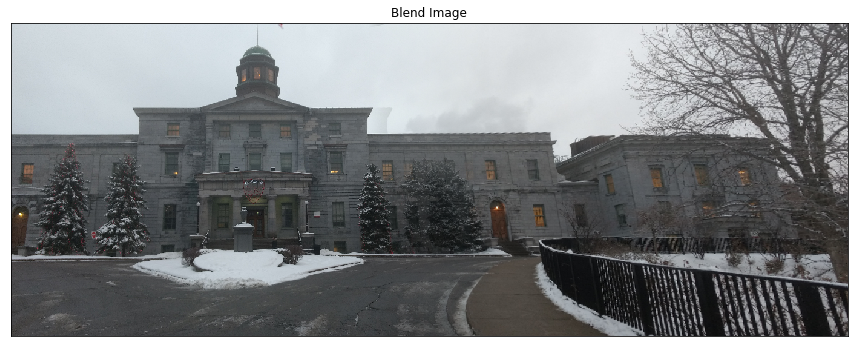

In [10]:
"""
Image Stitching using an Implemented Version of RANSAC
ECSE415 Fall 2017, Assignment #2, Problem 2

Author: Gary Corcoran
Date: Oct. 20th, 2017

"""
import cv2
import numpy as np
import matplotlib.pyplot as plt

""" Compute Sift Features """
def compute_sift(img1_gray, img2_gray):
    """
    Compute SIFT features between image pairs
    :param img1: left grayscale image
    :param img2: right grayscale image
    :return: list of sift keypoints and descriptors
                for both images (kp1, des1, kp2, des2)
    """
    # find SIFT features
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1_gray, None)
    kp2, des2 = sift.detectAndCompute(img2_gray, None)
    return kp1, des1, kp2, des2

""" Match Sift Features """
def match_sift(kp1, des1, kp2, des2):
    """
    Match SIFT descriptors
    :param kp1: left image keypoints
    :param des1: left image descriptors
    :param kp2: right image keypoints
    :param des2: right image descriptors
    :return pts1, pts2: matched points
    """
    # match features
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    pts1, pts2 = retrieve_points(kp1, kp2, matches)
    return pts1, pts2

""" Retrieve Points from Keypoint Object """
def retrieve_points(kp1, kp2, matches):
    """
    Retrieve matched points from kp1 and kp2
    :param kp1: left image keypoints
    :param kp2: right image keypoints
    :param matches: matched keypoint descriptors
    """
    # placeholder for matched point coordinates
    pts1 = np.empty((len(matches), 2))
    pts2 = np.empty((len(matches), 2))
    for i in range(len(matches)):
        pts1[i, :] = np.array(kp1[matches[i].queryIdx].pt)
        pts2[i, :] = np.array(kp2[matches[i].trainIdx].pt)
    return pts1, pts2

""" Compute Homography """
def random_homography(srcPts, dstPts, K):
    """
    Find Homography matrix from K random matched pairs
    :param srcPts: matched points from source image
    :param dstPts: matched points from destination image
    :param K: number of matched pairs to use in homography
            @pre: K >= 4
    :return M: homography matrix
    """
    # find random 4 pairs of points
    idx = np.random.randint(len(srcPts), size=K)
    # compute homography
    M = cv2.findHomography(srcPts[idx], dstPts[idx], 0)
    return M[0]

""" Compute Distance """
def compute_distance(pt1, pt2, thres):
    """
    Computes Euclidean distance between two points and compare
        to threshold
    :param pt1: point 1
    :param pt2: point 2
    :param thres: threshold to compare to distance
    :return: true if the distance is smaller than threshold,
                else false
    """
    dist = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
    if (dist < thres):
        return True
    else:
        return False

""" Project Points """
def project_points(srcPts, dstPts, M, thres):
    """
    Project points using homography matrix M
    :param srcPts: matched points from source image
    :param dstPts: matched points from destination image
    :param M: homography matrix
    :param thres: threshold for finding inliers
    :return inliers: number of inliers
            inliers_src: inliers in source image
            inliers_dst: inliers in destination image
    """
    # convert to homogeneous representation
    srcPts_hom = np.hstack((srcPts, np.ones((len(srcPts), 1))))
    # count number of inliers
    inliers = 0
    # store inlier points
    inliers_src = []
    inliers_dst = []
    for i, pt in enumerate(srcPts_hom):
        # computer projected point
        pt_new = np.dot(M, pt)
        # convert to back to homogeneous representation
        if pt_new[-1] is not 0:
            pt_new /= pt_new[-1]
        # if distance is smaller than threshold
        if (compute_distance(pt_new, dstPts[i], thres)):
            inliers += 1
            inliers_src.append(srcPts[i])
            inliers_dst.append(dstPts[i])
    return inliers, inliers_src, inliers_dst

""" Runs RANSAC Algorithm """
def run_ransac(srcPts, dstPts, K, thres, N):
    """
    Performs the RANSAC algorithm
    :param srcPts: matched points from source image
    :param dstPts: matched points from destination image
    :param K: number of matched points to use in
                computing homography @pre K > 4
    :param thres: threshold for finding inliers
    :param N: number of times to run RANSAC
    :return best_M: project matrix with highest
                number of inliers
    """
    best_inliers = 0
    for i in range(N):
        # compute homography from K random points
        M = random_homography(srcPts, dstPts, K)
        # project points using homography
        inliers, in_src, in_dst = project_points(srcPts, dstPts, M, thres)
        if inliers > best_inliers:
            best_inliers = inliers
            # store inliers
            inlier_src = [(round(pt[0]), round(pt[1])) for pt in in_src]
            inlier_dst = [(round(pt[0]), round(pt[1])) for pt in in_dst]
    # find homography matrix best on largest number of inliers
    M = cv2.findHomography(np.array(inlier_src), np.array(inlier_dst), 0)[0]
    return M

def find_output_limits(M, img1, img2):
    # top left
    tl = np.dot(M, np.array([0, 0, 1]))
    if tl[-1] is not 0:
        tl /= tl[-1]
    # bottom left
    bl = np.dot(M, np.array([0, img2.shape[1]-1, 1]))
    if bl[-1] is not 0:
        bl /= bl[-1]
    # create 3x3 translation matrix
    xMax = max(tl[1], bl[1])
    T = np.array([[1,0,-xMax//2], [0,1,0], [0,0,1]])
    # apply transformation
    M = np.dot(T, M)
    return M

def blend(img1, img2, blend_line, ramp_size):
    """ ALPHA BLENDING """
    def Ramp(i_width, r_width, r_index, start, end):
        """
        Create alpha blending function
        :param i_width: img width
        :param r_width: ramp width
        :param r_index: center ramp index
        :param start: starting ramp value
        :param end: ending ramp value
        :return:
        """
        a = np.zeros((i_width))
        step = (end - start) / (r_width-1)
        idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
        for i in range(r_width):
            a[idx] = start + step*i
            idx += 1
        a[idx:] = 1
        return a
     
    # alpha blending ramp
    alpha = Ramp(img1.shape[1], ramp_size, blend_line, 0, 1)
    
    # blend each channel separately
    ba, ga, ra = cv2.split(img1)
    bb, gb, rb = cv2.split(img2)
    # blending equation
    b_blend = (1-alpha) * ba + alpha*bb
    g_blend = (1-alpha) * ga + alpha*gb
    r_blend = (1-alpha) * ra + alpha*rb
    I_blend = cv2.merge((b_blend, g_blend, r_blend))
    I_blend = np.uint8(I_blend)  # convert back to uint8
    return I_blend
    
if __name__ == '__main__':
    # read images
    A = cv2.imread("McGill1.jpg")
    B = cv2.imread("McGill2.jpg")
    # resize images
    A = cv2.resize(A, None, fx=0.20, fy=0.20)
    B = cv2.resize(B, None, fx=0.20, fy=0.20)
    # convert to grayscale
    A_gray = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
    B_gray = cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)
    # compute SIFT
    kp1, des1, kp2, des2 = compute_sift(A_gray, B_gray)
    # match desriptors
    pts1, pts2 = match_sift(kp1, des1, kp2, des2)
    # run RANSAC algorithm
    M = run_ransac(pts2, pts1, K=4, thres=20, N=200)
    # find output size and shift warped image
    M = find_output_limits(M, A, B)
    # apply transform
    img_warp = cv2.warpPerspective(B, M, (A.shape[1], A.shape[0]))
    # align images
    blend_line = B.shape[1]//2
    img1 = np.zeros((A.shape[0], A.shape[1] + blend_line, 3))
    img2 = np.zeros((A.shape[0], A.shape[1] + blend_line, 3))
    img1[:, :A.shape[1]] = A
    img2[:, A.shape[1]-blend_line:] = img_warp
    
    # perform blending
    res = blend(img1, img2, img1.shape[1]//2, 200)
    
    # display figures
    plt.figure(figsize=(15,15))
    plt.subplot(121), plt.imshow(cv2.cvtColor(A, cv2.COLOR_BGR2RGB))
    plt.title("Image 1"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(cv2.cvtColor(B, cv2.COLOR_BGR2RGB))
    plt.title("Image 2"), plt.xticks([]), plt.yticks([])

    plt.figure(figsize=(15,15))
    plt.subplot(121), plt.imshow(cv2.cvtColor(np.uint8(img1), cv2.COLOR_BGR2RGB))
    plt.title("Image 1"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(cv2.cvtColor(np.uint8(img2), cv2.COLOR_BGR2RGB))
    plt.title("Warp Image2"), plt.xticks([]), plt.yticks([])
    
    plt.figure(figsize=(15,15))
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    plt.title("Blend Image"), plt.xticks([]), plt.yticks([])
    plt.show()